In [2]:
# Libraries.
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix, make_scorer
from sklearn.utils import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json

In [ ]:
# Import vectorized datasets.
major_train_de = pd.read_csv('../output-data/news-2/news2_train_vectorized_all_metrics_add_features_final.csv', sep=',')
hold_out_de = pd.read_csv('../output-data/news-2/news2_test_vectorized_all_metrics_add_features_final.csv', sep=',')

In [4]:
# Extract labels.
print(major_train_de.shape)

major_train_de_labels = major_train_de['is_true'].copy()
major_train_de.drop(columns=['is_true'], inplace=True)

hold_out_de_labels = hold_out_de['is_true'].copy()
hold_out_de.drop(columns=['is_true'], inplace=True)

(44191, 3028)


In [26]:
print('Test labels class distribution:')
print(hold_out_de_labels.value_counts(normalize=True))

Test labels class distribution:
is_true
1    0.921717
0    0.078283
Name: proportion, dtype: float64


In [27]:
print('Train labels class distribution:')
print(major_train_de_labels.value_counts(normalize=True))

Train labels class distribution:
is_true
1    0.921734
0    0.078266
Name: proportion, dtype: float64


In [6]:
# Compute class weights (due to class disbalance).
class_weight = compute_class_weight(
    class_weight="balanced",
    classes=major_train_de_labels.unique(),
    y=major_train_de_labels
)
print(f'New class weights: {class_weight}.')

New class weights: [0.54247379 6.38598266].


In [5]:
print('Training Logistic Regression.')
log_reg_model = LogisticRegression(
    class_weight={
        1: class_weight[0],
        0: class_weight[1]
    }
)
log_reg_model.fit(major_train_de, major_train_de_labels)
predictions = log_reg_model.predict(hold_out_de)
print(f'\nLogReg accuracy: {accuracy_score(hold_out_de_labels, predictions):.5f}')
print(f'LogReg recall: {recall_score(hold_out_de_labels, predictions):.5f}')
print(f'Confusion matrix:\n{confusion_matrix(hold_out_de_labels, predictions)}\n')

# Classification report for Logistic Regression:
print('[Logistic Regression].')
print(classification_report(hold_out_de_labels, predictions))

Training Logistic Regression.

LogReg accuracy: 0.94510
LogReg recall: 0.94909
Confusion matrix:
[[  863    98]
 [  576 10739]]

[Logistic Regression].
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       961
           1       0.99      0.95      0.97     11315

    accuracy                           0.95     12276
   macro avg       0.80      0.92      0.84     12276
weighted avg       0.96      0.95      0.95     12276


In [6]:
def get_feature_importance(model):
    coefs = list(model.coef_[0])
    feat_names = list(model.feature_names_in_)
    indices = list(range(len(feat_names)))

    imps = [(i, n, c) for i, n, c in zip(indices, feat_names, coefs)]
    imps = sorted(imps, key = lambda x: abs(x[2]), reverse = True)
    # print(imps[:50])
    return imps

def get_importance_graph(imp_list, model_name: str, scale: bool = True):
    negative_imps = sorted([(i[1], i[2]) for i in imp_list if i[2] < 0], key = lambda x: abs(x[1]), reverse = True)
    positive_imps = sorted([(i[1], i[2]) for i in imp_list if i[2] > 0], key = lambda x: abs(x[1]), reverse = True)
    top_negative = negative_imps[:20]
    top_positive = positive_imps[:20]
    top_general = top_negative + top_positive
    top_general = sorted(top_general, key = lambda x: (x[1]), reverse = True)

    names = [j[0] for j in top_general]
    vals = [k[1] for k in top_general]
    if scale:
        max_abs = max(abs(vals[0]), abs(vals[-1]))
        vals = [v/max_abs for v in vals]

    plt.figure(figsize = (12, 8))
    sns.barplot(x = vals, y = names, color = 'b')
    plt.xlabel('Feature importance', fontsize = 12)
    plt.ylabel('Feature names', fontsize = 12)
    plt.title(f'Top-20 positive and negative features for {model_name}', fontsize = 14)
    plt.show()

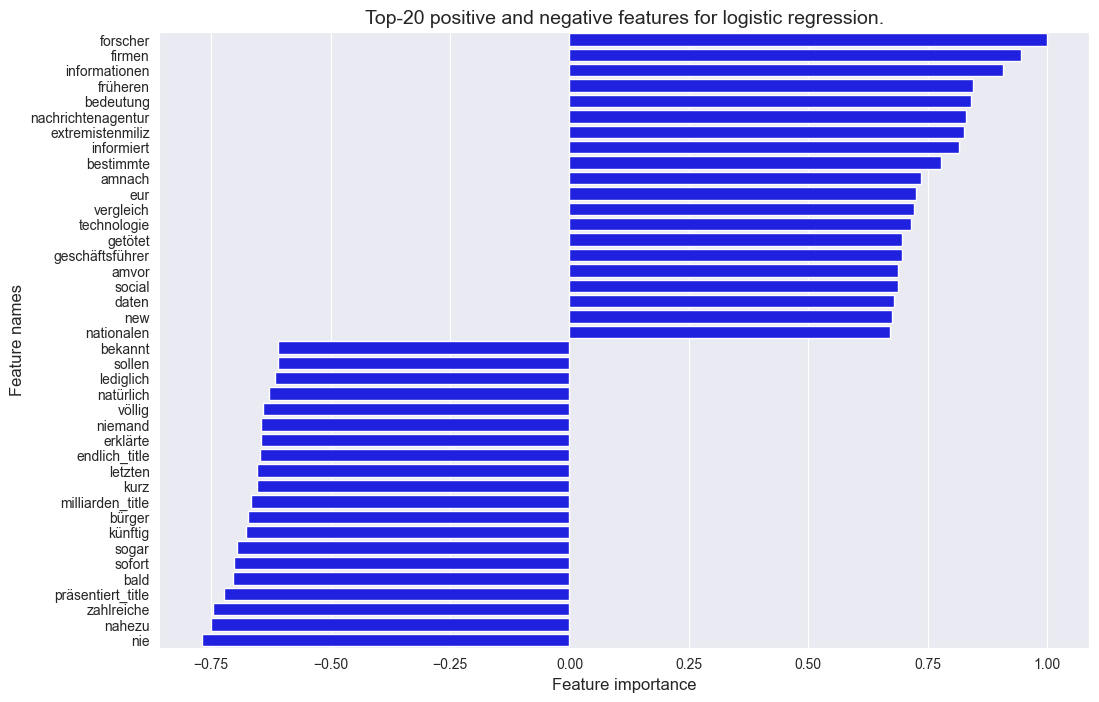

In [7]:
lr_f_importances = get_feature_importance(log_reg_model)
get_importance_graph(lr_f_importances, model_name='logistic regression.')

## Model Cross-Validation.

In [6]:
# Generate random states.
random_states: list[int] = []
for i in range(0, 5):
    random_states.append(random.randint(20, 99))
    
random_states

[84, 47, 59, 57, 84]

In [9]:
all_results: dict = {}
best_estimators: list = []

debug_print = True

for idx, el in enumerate(random_states):
    kfold = StratifiedKFold(n_splits=5, random_state=el, shuffle=True)
    log_reg_model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=1, verbose=50, class_weight={
        1: class_weight[0],
        0: class_weight[1]
    })
    results = cross_validate(
        log_reg_model,
        major_train_de,
        major_train_de_labels,
        cv=kfold,
        verbose=50,
        return_train_score=True,
        return_indices=True,
        return_estimator=True,
        n_jobs=-1
    )
    
    # Find max test_score and write statistics to a dict.

    all_results[f'run_{str(idx+1)}'] = {}
    max_score = 0
    max_idx = -1
    for i, elem in enumerate(results['indices']['train']):
        all_results[f'run_{str(idx+1)}'][str(i)] = {
            'train_length': len(elem),
            'test_length': len(results['indices']['test'][i]),
            'test_score': results['test_score'][i]
        }
        if max_score < results['test_score'][i]:
            max_score = results['test_score'][i]
            max_idx = i
    best_estimators.append(results['estimator'][max_idx])
    all_results[f'run_{str(idx+1)}']['best_estimator_index'] = max_idx
    
    if debug_print:
        print(json.dumps(all_results, indent=4))
        debug_print = False

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
{
    "run_1": {
        "0": {
            "train_length": 39281,
            "test_length": 9821,
            "test_score": 0.9242439670094695
        },
        "1": {
            "train_length": 39281,
            "test_length": 9821,
            "test_score": 0.9457285408817839
        },
        "2": {
            "train_length": 39282,
            "test_length": 9820,
            "test_score": 0.9453156822810591
        },
        "3": {
            "train_length": 39282,
            "test_length": 9820,
            "test_score": 0.895519348268839
        },
        "4": {
            "train_length": 39282,
      

In [10]:
print(json.dumps(all_results, indent=4))
len(best_estimators)

{
    "run_1": {
        "0": {
            "train_length": 39281,
            "test_length": 9821,
            "test_score": 0.9242439670094695
        },
        "1": {
            "train_length": 39281,
            "test_length": 9821,
            "test_score": 0.9457285408817839
        },
        "2": {
            "train_length": 39282,
            "test_length": 9820,
            "test_score": 0.9453156822810591
        },
        "3": {
            "train_length": 39282,
            "test_length": 9820,
            "test_score": 0.895519348268839
        },
        "4": {
            "train_length": 39282,
            "test_length": 9820,
            "test_score": 0.9557026476578412
        },
        "best_estimator_index": 4
    },
    "run_2": {
        "0": {
            "train_length": 39281,
            "test_length": 9821,
            "test_score": 0.9437939110070258
        },
        "1": {
            "train_length": 39281,
            "test_length": 9821,
           

5

In [11]:
# Select best of the best model.

best_score = 0
best_estimator_idx = -1

for idx, run_key in enumerate(all_results.keys()):
    best_of_run = all_results[run_key][str(all_results[run_key]['best_estimator_index'])]
    print(f'Best score for run {run_key}: {best_of_run['test_score']}. Model index: {all_results[run_key]['best_estimator_index']}.')
    if best_score < best_of_run['test_score']:
        best_score = best_of_run['test_score']
        best_estimator_idx = idx

print(f'Best of the best: #{best_estimator_idx}.')

Best score for run run_1: 0.9557026476578412. Model index: 4.
Best score for run run_2: 0.944908350305499. Model index: 3.
Best score for run run_3: 0.9485795743814276. Model index: 1.
Best score for run run_4: 0.9447046843177189. Model index: 4.
Best score for run run_5: 0.9323897770084513. Model index: 1.
Best of the best: #0.


In [12]:
test_model = best_estimators[best_estimator_idx]
hold_out_prediction = test_model.predict(hold_out_de)

In [13]:

print(f'\nLogReg accuracy: {accuracy_score(hold_out_de_labels, hold_out_prediction):.5f}')
print(f'LogReg recall: {recall_score(hold_out_de_labels, hold_out_prediction):.5f}')
print(f'Confusion matrix:\n{confusion_matrix(hold_out_de_labels, hold_out_prediction)}\n')

print('[Logistic Regression].')
print(classification_report(hold_out_de_labels, hold_out_prediction, digits=5))


LogReg accuracy: 0.95601
LogReg recall: 0.97066
Confusion matrix:
[[  753   208]
 [  332 10983]]

[Logistic Regression].
              precision    recall  f1-score   support

           0    0.69401   0.78356   0.73607       961
           1    0.98141   0.97066   0.97601     11315

    accuracy                        0.95601     12276
   macro avg    0.83771   0.87711   0.85604     12276
weighted avg    0.95891   0.95601   0.95722     12276


## Model Fine Tuning.

In [7]:
ft_log_reg = LogisticRegression(n_jobs=-1, random_state=84, class_weight={
        1: class_weight[0],
        0: class_weight[1]
    })

parameters = {
    'fit_intercept': [True, False],
    # 'class_weight': [None, 'balanced'],
    'solver': ['saga'],
    'l1_ratio': [0, 1],
    'C': [100, 1.0, 0.1],
    'penalty': ['l1', 'l2', 'elasticnet']
}

scorers = {
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [8]:
df = pd.concat([major_train_de, hold_out_de])
df_labels = pd.concat([major_train_de_labels, hold_out_de_labels])

def apply_greed_search(classifier, parameters, scorers, refit_score='accuracy_score'):

    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(classifier,
                               parameters,
                               scoring=scorers,
                               refit=refit_score,
                               cv=skf,
                               return_train_score=True,
                               n_jobs=19, verbose=2)
    
    grid_search.fit(df.values, df_labels.values)
    return grid_search

In [9]:
grid_search_clf = apply_greed_search(
    classifier=ft_log_reg,
    parameters=parameters,
    scorers=scorers,
    refit_score='accuracy_score'
)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


D:\Neuro\GDK_project_venv\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Neuro\GDK_project_venv\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [10]:
results = pd.DataFrame(grid_search_clf.cv_results_)

In [11]:
results_acc = results.sort_values(by='mean_test_accuracy_score', ascending=False)

results_acc[
    [
        'mean_test_recall_score',
        'mean_test_accuracy_score',
        'param_C',
        'param_solver',
        'param_fit_intercept',
        'param_penalty',
        'param_l1_ratio'
    ]
].round(5).sort_values(by='mean_test_accuracy_score', ascending=False).head()

mean_test_recall_score  mean_test_accuracy_score param_C param_solver  \
2                  0.95896                   0.94763     100         saga   
4                  0.95896                   0.94763     100         saga   
1                  0.95896                   0.94763     100         saga   
10                 0.95744                   0.94622     100         saga   
7                  0.95744                   0.94622     100         saga   

   param_fit_intercept param_penalty param_l1_ratio  
2                 True    elasticnet              0  
4                 True            l2              1  
1                 True            l2              0  
10               False            l2              1  
7                False            l2              0

In [13]:
results_rec = results.sort_values(by='mean_test_recall_score', ascending=False)

results_rec[
    [
        'mean_test_recall_score',
        'mean_test_accuracy_score',
        'param_l1_ratio',
        'param_penalty',
        'param_C',
        'param_solver',
        'param_fit_intercept'
    ]
].round(6).sort_values(by='mean_test_recall_score', ascending=False).head(5)

mean_test_recall_score  mean_test_accuracy_score param_l1_ratio  \
2                 0.958959                  0.947633              0   
4                 0.958959                  0.947633              1   
1                 0.958959                  0.947633              0   
9                 0.958191                  0.946199              1   
11                0.958191                  0.946199              1   

   param_penalty param_C param_solver param_fit_intercept  
2     elasticnet     100         saga                True  
4             l2     100         saga                True  
1             l2     100         saga                True  
9             l1     100         saga               False  
11    elasticnet     100         saga               False

In [ ]:
results


In [ ]:
# Model with the best accuracy:
results.iloc[21][[
        'split4_test_accuracy_score',
        'param_C',
        'param_solver',
        'param_fit_intercept',
        'param_class_weight']]

In [ ]:
# Model with the best recall:
results.iloc[27][[
        'split4_test_recall_score',
        'param_C',
        'param_solver',
        'param_fit_intercept',
        'param_class_weight']]

In [14]:
# Accuracy.

print('Training Logistic Regression.')
log_reg_model_refined = LogisticRegression(solver='saga', C=100, fit_intercept=True, penalty='elasticnet', l1_ratio=0)
log_reg_model_refined.fit(major_train_de, major_train_de_labels)

Training Logistic Regression.


D:\Neuro\GDK_project_venv\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=100, l1_ratio=0, penalty='elasticnet', solver='saga')

In [15]:
predictions = log_reg_model_refined.predict(hold_out_de)
print(f'\nLogReg accuracy: {accuracy_score(hold_out_de_labels, predictions):.5f}')
print(f'LogReg recall: {recall_score(hold_out_de_labels, predictions):.5f}')
print(f'Confusion matrix:\n{confusion_matrix(hold_out_de_labels, predictions)}\n')

# Classification report for Logistic Regression:
print('[Logistic Regression - hold-out set - refined].')
print(classification_report(hold_out_de_labels, predictions, digits=5))


LogReg accuracy: 0.96074
LogReg recall: 0.98082
Confusion matrix:
[[  696   265]
 [  217 11098]]

[Logistic Regression - hold-out set - refined].
              precision    recall  f1-score   support

           0    0.76232   0.72425   0.74280       961
           1    0.97668   0.98082   0.97875     11315

    accuracy                        0.96074     12276
   macro avg    0.86950   0.85253   0.86077     12276
weighted avg    0.95990   0.96074   0.96028     12276
